In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
# Sources

rain = pd.read_csv('rain_data_aus.csv')

wind_table_01 = pd.read_csv('wind_table_01.csv')
wind_table_02 = pd.read_csv('wind_table_02.csv')
wind_table_03 = pd.read_csv('wind_table_03.csv')
wind_table_04 = pd.read_csv('wind_table_04.csv')
wind_table_05 = pd.read_csv('wind_table_05.csv')
wind_table_06 = pd.read_csv('wind_table_06.csv')
wind_table_07 = pd.read_csv('wind_table_07.csv')
wind_table_08 = pd.read_csv('wind_table_08.csv')

cities = list(rain['location'].unique())

In [4]:
# Categorical pipeline components

categorical_imputer = SimpleImputer(strategy='most_frequent')
onehotencoder = OneHotEncoder(drop='first',  handle_unknown='error')

In [5]:
# Categorical pipeline

categorical_pipeline = Pipeline(steps=[('missing', categorical_imputer),
                                       ('encode', onehotencoder)])

In [6]:
# Numerical pipeline components

numerical_imputer_knn = KNNImputer()

In [7]:
# Numerical pipeline

numerical_pipeline = Pipeline(steps=[('missing', numerical_imputer_knn)])

In [8]:
# Model

scaler = StandardScaler()
model_lgbm = LGBMClassifier()

In [18]:
prediction_r = []
score_r =[]

cities_up = []
up_score = []
up_recall = []
up_precision = []

cities_inter = []
inter_score = []
inter_recall = []
inter_precision = []


cities_under = []
under_score = []
under_recall = []
under_precision = []

for i in cities:
    
    trial_r = rain[rain['location'] == i][['date', 'humidity3pm', 'humidity9am', 'pressure3pm', 'pressure9am', 'temp3pm', 'temp9am', 'raintomorrow']]
    
    
    trial_w = wind_table_01[wind_table_01['location'] == i]
    trial_w = trial_w.append(wind_table_02[wind_table_02['location'] == i])
    trial_w = trial_w.append(wind_table_03[wind_table_03['location'] == i])
    trial_w = trial_w.append(wind_table_04[wind_table_04['location'] == i])
    trial_w = trial_w.append(wind_table_05[wind_table_05['location'] == i])
    trial_w = trial_w.append(wind_table_06[wind_table_06['location'] == i])
    trial_w = trial_w.append(wind_table_07[wind_table_07['location'] == i])
    trial_w = trial_w.append(wind_table_08[wind_table_08['location'] == i])
    
    
    trial_c = trial_r.merge(trial_w, left_on='date', right_on='date')
    
    
    
    
    X = trial_c[['humidity3pm', 'humidity9am', 'pressure3pm', 'pressure9am', 'temp3pm', 'temp9am', 'wind_speed9am', 'windspeed9am',
            'wind_speed3pm', 'windspeed3pm']]
    y = trial_c['raintomorrow']
                                      
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state = 42)
                                          
    cat_columns = list(X_train.select_dtypes('object').columns)
    num_columns = list(X_train.select_dtypes(exclude='object').columns)
                                      
    dataprep = ColumnTransformer(transformers=[('numerical_transform', numerical_pipeline, num_columns),
                                                ('categ_transform', categorical_pipeline, cat_columns)])
    
    pipeline = Pipeline(steps=[('data', dataprep),
                                ('scaler', StandardScaler()),
                                ('model', model_lgbm)])
                                      
    pipeline.fit(X_train, y_train)
                                      
    prediction_v = pipeline.predict(X_valid)
    
    
    score_v = pipeline.score(X_valid, y_valid)
    recall_v = recall_score(y_valid == 'Yes', pipeline.predict(X_valid) == 'Yes')
    precision_v = precision_score(y_valid == 'Yes', pipeline.predict(X_valid) == 'Yes')
    
    
    if score_v < 0.85:
        
        cities_under.append(i)
        under_score.append(score_v)
        under_recall.append(recall_v)
        under_precision.append(precision_v)
        
        
    elif (score_v > 0.85)&(score_v < 0.90):
        
        cities_inter.append(i)
        inter_score.append(score_v)
        inter_recall.append(recall_v)
        inter_precision.append(precision_v)
        
        
    else:
        
        cities_up.append(i)
        up_score.append(score_v)
        up_recall.append(recall_v)
        up_precision.append(precision_v)

    
    print(i)
    print(score_v)
    print(recall_v)
    print(precision_v)
    
    score_r.append(score_v)
    
print(sum(score_r)/len(score_r))


Albury
0.8847457627118644
0.6475409836065574
0.7596153846153846
BadgerysCreek
0.8865619546247818
0.5398230088495575
0.8243243243243243
Cobar
0.9111111111111111
0.5769230769230769
0.703125
CoffsHarbour
0.8364888123924269
0.621301775147929
0.7720588235294118
Moree
0.925531914893617
0.620253164556962
0.8032786885245902
Newcastle
0.7772020725388601
0.34965034965034963
0.5813953488372093
NorahHead
0.8249566724436742
0.5345911949685535
0.7589285714285714
NorfolkIsland
0.8052173913043478
0.5722222222222222
0.7463768115942029
Penrith
0.8605851979345955
0.5
0.7037037037037037
Richmond
0.8862068965517241
0.5454545454545454
0.7894736842105263
Sydney
0.846749226006192
0.6011904761904762
0.7593984962406015
SydneyAirport
0.8115449915110357
0.47019867549668876
0.696078431372549
WaggaWagga
0.9032815198618307
0.5981308411214953
0.8311688311688312
Williamtown
0.8070866141732284
0.5179856115107914
0.6990291262135923
Wollongong
0.833904109589041
0.4492753623188406
0.7469879518072289
Canberra
0.88315629742

In [10]:
# Evaluation

zip_under = zip(cities_under, under_score)
dict_under = dict(zip_under)

zip_inter = zip(cities_inter, inter_score)
dict_inter = dict(zip_inter)

zip_up = zip(cities_up, up_score)
dict_up = dict(zip_up)

In [11]:
data_under = pd.DataFrame()
data_inter = pd.DataFrame()
data_up = pd.DataFrame()

In [12]:
data_under[['cities','score', 'recall', 'precision', 'label' ]] = [dict_under.keys(), dict_under.values(), under_recall, under_precision,  1]

data_inter[['cities','score', 'recall', 'precision', 'label' ]] = [dict_inter.keys(), dict_inter.values(), inter_recall, inter_precision,  2]

data_up[['cities','score', 'recall', 'precision', 'label' ]] = [dict_up.keys(), dict_up.values(), up_recall, up_precision,  3]

In [13]:
data_ev = data_under.append(data_inter, ignore_index = True)
data_ev = data_ev.append(data_up, ignore_index = True)

In [14]:
data_ev.to_csv('data_ev.csv', index = False)

In [21]:
import seaborn as sns

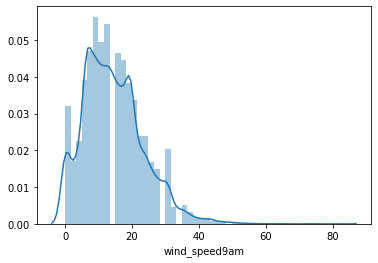

In [31]:
sns.distplot(wind_table_01['wind_speed9am'])